# SUSTAV ZA DETEKCIJU KARAKTERISTIČNIH TOČAKA LICA
Toni Polanec 2023.


In [165]:

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import math
from sklearn.impute import SimpleImputer
from tqdm.keras import TqdmCallback
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam


## Analiza podataka

In [41]:
# učitanje slika
face_images = np.load('face_images.npz')
faces=face_images.get(face_images.files[0]) 

# oblikovanje polja
faces=np.moveaxis(faces,-1,0)
faces=faces.reshape(faces.shape[0],faces.shape[1],faces.shape[1],1)

In [42]:
faces.shape

(7049, 96, 96, 1)

Ukupno imamo **7049** različitih slika.  
Svaka slika je veličine **96x96** piksela. 


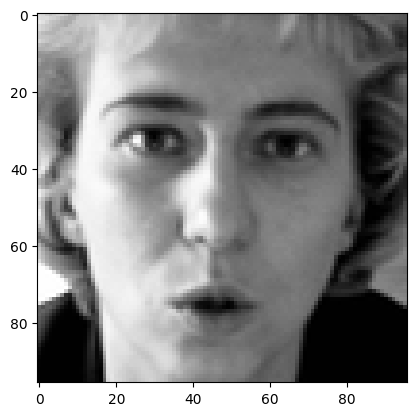

In [43]:
plt.imshow(faces[1], cmap='gray')

^ primjer slike

In [200]:
# čitanje datoteke s karakterističnim točkama lica
landmarks = pd.read_csv('facial_keypoints.csv')
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


Korišteni dataset ima sveukupno 15 karakterističnih točaka lica.  
U ovom radu koristit ćemo samo 9 točaka, i to:
- centar lijevog oka
- lijevi rub lijevog oka
- desni rub desnog oka

- centar desnog oka
- lijevi rub desnog oka
- desni rub desnog oka
  
- vrh nosa
  
- centar gornje usne
- centar donje usne

In [201]:
# brisanje podataka o obrvama i ustima (osim bottom_lip_center)
landmarks = landmarks.drop(['left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y'], axis=1)

In [202]:
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,nose_tip_x,nose_tip_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,44.420571,57.066803,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,48.206298,55.660936,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,47.557263,53.538947,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,51.885078,54.166539,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,43.299534,64.889521,44.962748,73.707387,44.227141,86.871166


In [204]:
landmarks.shape

(7049, 18)

Za svaku sliku imamo 18 parametara koji predstavljaju koordinate 9 različitih točaka na licu (x,y).  
<br>
Zbog nepravilnosti dataseta moramo provjeriti koliko ima nepostojećih vrijednosti.

In [205]:
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
nose_tip_x                      0
nose_tip_y                      0
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_bottom_lip_y      33
dtype: int64

Vidimo da ih ima dosta pa ćemo to sanirati u sljedećim koracima.

#### Prikaz tablice korelacije između karakterističnih točaka lica:

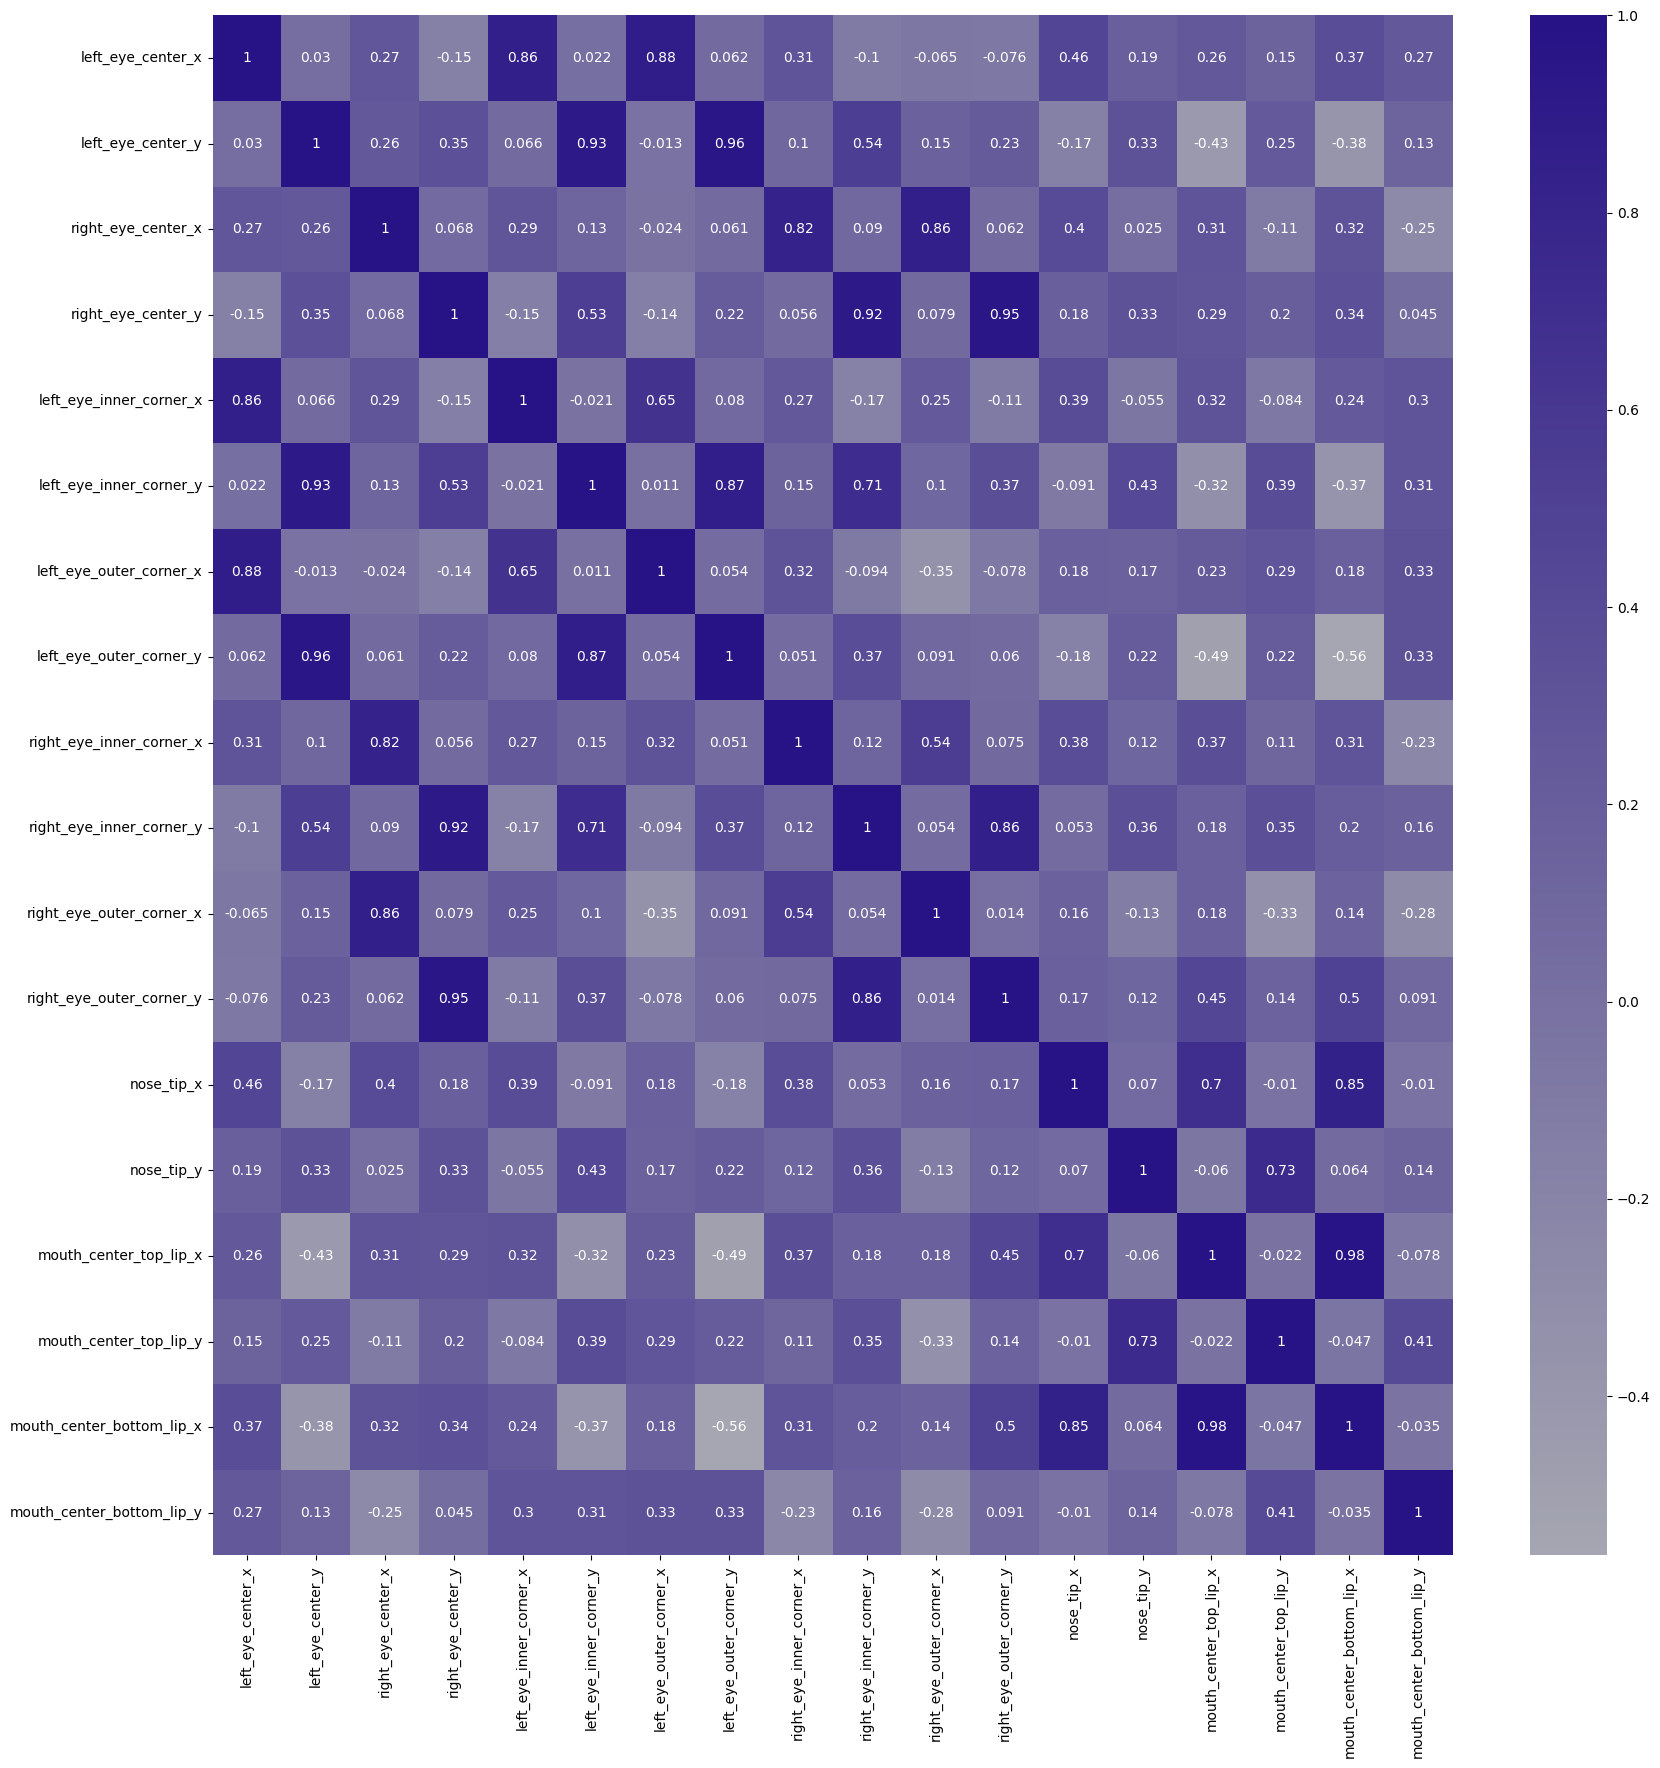

In [206]:
landmarks_correlation = landmarks.corr()

plt.figure(figsize=(20,20))
sns.heatmap(landmarks_correlation, cmap=sns.color_palette("blend:#A5A6B1,#271286", as_cmap=True), annot=True)
plt.show()


Po grafu iznad vidimo da imamo korelacije između nekih točaka u datasetu. Npr. *right_eye_center_x* i *right_eye_outer_corner_x* imaju korelaciju od 0.86.  
To ćemo iskoristiti da popunimo null vrijednosti u datasetu.  
<br>
Npr. uz pomoć točke centra oka ćemo izračunati točke vanjskog i unutarnjeg ruba oka.



## Predprocesiranje podataka

Po analizi podataka dobili smo informaciju da za karakterističnu točku *eye_center* fali samo 13 vrijednosti. Pa umijesto da izmišljam vrijednosti za te točke, odlučio sam ih izbaciti iz dataseta.



In [208]:
empty_rows = landmarks[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y']].isnull().any(axis=1)
null_indexes = landmarks[empty_rows].index

# brisanje slika koje imaju te određene točke s null vrijednostima
faces = np.delete(faces, null_indexes, axis=0)
landmarks = landmarks.dropna(subset=['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y'], how='any')


print("landmarks.shape ->", landmarks.shape)
# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()


landmarks.shape -> (7033, 18)


left_eye_center_x               0
left_eye_center_y               0
right_eye_center_x              0
right_eye_center_y              0
left_eye_inner_corner_x      4773
left_eye_inner_corner_y      4773
left_eye_outer_corner_x      4776
left_eye_outer_corner_y      4776
right_eye_inner_corner_x     4771
right_eye_inner_corner_y     4771
right_eye_outer_corner_x     4771
right_eye_outer_corner_y     4771
nose_tip_x                      0
nose_tip_y                      0
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_bottom_lip_y      33
dtype: int64

Isto tako za *mouth_center_bottom_lip* fali 33 vrijednosti, pa ćemo i njih izbaciti iz dataseta.


In [49]:
empty_rows = landmarks[['mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']].isnull().any(axis=1)
null_indexes = landmarks[empty_rows].index

# brisanje slika koje imaju te određene točke s null vrijednostima
faces = np.delete(faces, null_indexes, axis=0)
landmarks = landmarks.dropna(subset=['mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'], how='any')

# provjera koliko null vrijednosti imamo u svakom stupcu
landmarks.isnull().sum()

left_eye_center_x               0
left_eye_center_y               0
right_eye_center_x              0
right_eye_center_y              0
left_eye_inner_corner_x      4763
left_eye_inner_corner_y      4763
left_eye_outer_corner_x      4765
left_eye_outer_corner_y      4765
right_eye_inner_corner_x     4761
right_eye_inner_corner_y     4761
right_eye_outer_corner_x     4760
right_eye_outer_corner_y     4760
left_eyebrow_inner_end_x     4764
left_eyebrow_inner_end_y     4764
left_eyebrow_outer_end_x     4806
left_eyebrow_outer_end_y     4806
right_eyebrow_inner_end_x    4767
right_eyebrow_inner_end_y    4767
right_eyebrow_outer_end_x    4799
right_eyebrow_outer_end_y    4799
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4762
mouth_left_corner_y          4762
mouth_right_corner_x         4761
mouth_right_corner_y         4761
mouth_center_top_lip_x       4755
mouth_center_top_lip_y       4755
mouth_center_bottom_lip_x       0
mouth_center_b

### Popunjavanje null vrijednosti

In [50]:
# podjela na skup s null vrijednostima i skup bez null vrijednosti
landmarks_null = landmarks[landmarks.isnull().any(axis=1)]
landmarks_not_null = landmarks.dropna()

print(f"landmarks_null:{landmarks_null.shape}   landmarks_not_null:{landmarks_not_null.shape}")

landmarks_null:(4860, 30)   landmarks_not_null:(2140, 30)


Sad vidimo da imamo točku centra lijevog i desnog oka, pomoću tih koordinata izračunati ćemo koordinate točaka oko oka koje nedostaju.  
OČI:   *left_eye_inner_corner left_eye_outer_corner, right_eye_inner_corner right_eye_outer_corner*  
OBRVE: *left_eyebrow_inner_end left_eyebrow_outer, right_eyebrow_inner_end right_eyebrow_outer_end*  

Isto tako za usta, imamo točku donjeg centra usne.  
USTA:  *mouth_left_corner, mouth_right_corner mouth_center_top_lip*    



In [51]:
not_null_size = landmarks_not_null.shape[0]

# EYES

left_eye_inner_corner_x_avg_diff = (landmarks_not_null['left_eye_inner_corner_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
left_eye_inner_corner_y_avg_diff = (landmarks_not_null['left_eye_inner_corner_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

left_eye_outer_corner_x_avg_diff = (landmarks_not_null['left_eye_outer_corner_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
left_eye_outer_corner_y_avg_diff = (landmarks_not_null['left_eye_outer_corner_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

right_eye_inner_corner_x_avg_diff = (landmarks_not_null['right_eye_inner_corner_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
right_eye_inner_corner_y_avg_diff = (landmarks_not_null['right_eye_inner_corner_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size

right_eye_outer_corner_x_avg_diff = (landmarks_not_null['right_eye_outer_corner_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
right_eye_outer_corner_y_avg_diff = (landmarks_not_null['right_eye_outer_corner_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size


# EYEBROWS

left_eyebrow_inner_end_x_avg_diff = (landmarks_not_null['left_eyebrow_inner_end_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
left_eyebrow_inner_end_y_avg_diff = (landmarks_not_null['left_eyebrow_inner_end_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size
left_eyebrow_outer_end_x_avg_diff = (landmarks_not_null['left_eyebrow_outer_end_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
left_eyebrow_outer_end_y_avg_diff = (landmarks_not_null['left_eyebrow_outer_end_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

right_eyebrow_inner_end_x_avg_diff = (landmarks_not_null['right_eyebrow_inner_end_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
right_eyebrow_inner_end_y_avg_diff = (landmarks_not_null['right_eyebrow_inner_end_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size
right_eyebrow_outer_end_x_avg_diff = (landmarks_not_null['right_eyebrow_outer_end_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
right_eyebrow_outer_end_y_avg_diff = (landmarks_not_null['right_eyebrow_outer_end_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size

# MOUTH

mouth_left_corner_x_avg_diff = (landmarks_not_null['mouth_left_corner_x'].values - landmarks_not_null['mouth_center_bottom_lip_x'].values).sum() / not_null_size
mouth_left_corner_y_avg_diff = (landmarks_not_null['mouth_left_corner_y'].values - landmarks_not_null['mouth_center_bottom_lip_y'].values).sum() / not_null_size

mouth_right_corner_x_avg_diff = (landmarks_not_null['mouth_right_corner_x'].values - landmarks_not_null['mouth_center_bottom_lip_x'].values).sum() / not_null_size
mouth_right_corner_y_avg_diff = (landmarks_not_null['mouth_right_corner_y'].values - landmarks_not_null['mouth_center_bottom_lip_y'].values).sum() / not_null_size

mouth_center_top_lip_x_avg_diff = (landmarks_not_null['mouth_center_top_lip_x'].values - landmarks_not_null['mouth_center_bottom_lip_x'].values).sum() / not_null_size
mouth_center_top_lip_y_avg_diff = (landmarks_not_null['mouth_center_top_lip_y'].values - landmarks_not_null['mouth_center_bottom_lip_y'].values).sum() / not_null_size


print("\nLeft eye center\n" +
    f"left_eye_inner_corner_x_avg_diff:\t{left_eye_inner_corner_x_avg_diff}\n" +
    f"left_eye_inner_corner_y_avg_diff:\t{left_eye_inner_corner_y_avg_diff}\n" +
    f"left_eye_outer_corner_x_avg_diff:\t{left_eye_outer_corner_x_avg_diff}\n" +
    f"left_eye_outer_corner_y_avg_diff:\t{left_eye_outer_corner_y_avg_diff}\n" +
    "\nRight eye center\n" +
    f"right_eye_inner_corner_x_avg_diff:\t{right_eye_inner_corner_x_avg_diff}\n" +
    f"right_eye_inner_corner_y_avg_diff:\t{right_eye_inner_corner_y_avg_diff}\n" +
    f"right_eye_outer_corner_x_avg_diff:\t{right_eye_outer_corner_x_avg_diff}\n" +
    f"right_eye_outer_corner_y_avg_diff:\t{right_eye_outer_corner_y_avg_diff}\n" +
    "\nLeft eye center\n" +
    f"left_eyebrow_inner_end_x_avg_diff:\t{left_eyebrow_inner_end_x_avg_diff}\n" +
    f"left_eyebrow_inner_end_y_avg_diff:\t{left_eyebrow_inner_end_y_avg_diff}\n" +
    f"left_eyebrow_outer_end_x_avg_diff:\t{left_eyebrow_outer_end_x_avg_diff}\n" +
    f"left_eyebrow_outer_end_y_avg_diff:\t{left_eyebrow_outer_end_y_avg_diff}\n" +
    "\nRight eye center\n" +
    f"right_eyebrow_inner_end_x_avg_diff:\t{right_eyebrow_inner_end_x_avg_diff}\n" +
    f"right_eyebrow_inner_end_y_avg_diff:\t{right_eyebrow_inner_end_y_avg_diff}\n" +
    f"right_eyebrow_outer_end_x_avg_diff:\t{right_eyebrow_outer_end_x_avg_diff}\n" +
    f"right_eyebrow_outer_end_y_avg_diff:\t{right_eyebrow_outer_end_y_avg_diff}\n" +
    "\nMouth center bottom lip\n" +
    f"mouth_left_corner_x_avg_diff:   \t{mouth_left_corner_x_avg_diff}\n" +
    f"mouth_left_corner_y_avg_diff:   \t{mouth_left_corner_y_avg_diff}\n" +
    f"mouth_right_corner_x_avg_diff:  \t{mouth_right_corner_x_avg_diff}\n" +
    f"mouth_right_corner_y_avg_diff:  \t{mouth_right_corner_y_avg_diff}\n" +
    f"mouth_center_top_lip_x_avg_diff:\t{mouth_center_top_lip_x_avg_diff}\n" +
    f"mouth_center_top_lip_y_avg_diff:\t{mouth_center_top_lip_y_avg_diff}\n"
    )



Left eye center
left_eye_inner_corner_x_avg_diff:	-6.949420583473551
left_eye_inner_corner_y_avg_diff:	1.0137402881660746
left_eye_outer_corner_x_avg_diff:	7.190924750100281
left_eye_outer_corner_y_avg_diff:	0.7978355173541588

Right eye center
right_eye_inner_corner_x_avg_diff:	6.9628379537300935
right_eye_inner_corner_y_avg_diff:	0.8570367509893456
right_eye_outer_corner_x_avg_diff:	-7.2786514656024295
right_eye_outer_corner_y_avg_diff:	0.9707564230453272

Left eye center
left_eyebrow_inner_end_x_avg_diff:	-10.073557756659254
left_eyebrow_inner_end_y_avg_diff:	-7.619969716626402
left_eyebrow_outer_end_x_avg_diff:	13.395974481041963
left_eyebrow_outer_end_y_avg_diff:	-7.185703989326729

Right eye center
right_eyebrow_inner_end_x_avg_diff:	9.631815294100091
right_eyebrow_inner_end_y_avg_diff:	-7.650068310621402
right_eyebrow_outer_end_x_avg_diff:	-13.878561310490214
right_eyebrow_outer_end_y_avg_diff:	-6.610868191936355

Mouth center bottom lip
mouth_left_corner_x_avg_diff:   	15.2694

Sad imamo prosječne udaljenosti od poznatih točaka.  
Možemo popuniti sve null vrijednosti tako da dodamo ili oduzmemo prosječnu udaljenost od poznate točke.

In [52]:
# EYES
landmarks['left_eye_inner_corner_x'] = landmarks['left_eye_inner_corner_x'].fillna(landmarks['left_eye_center_x'] + left_eye_inner_corner_x_avg_diff)
landmarks['left_eye_inner_corner_y'] = landmarks['left_eye_inner_corner_y'].fillna(landmarks['left_eye_center_y'] + left_eye_inner_corner_y_avg_diff)

landmarks['left_eye_outer_corner_x'] = landmarks['left_eye_outer_corner_x'].fillna(landmarks['left_eye_center_x'] + left_eye_outer_corner_x_avg_diff)
landmarks['left_eye_outer_corner_y'] = landmarks['left_eye_outer_corner_y'].fillna(landmarks['left_eye_center_y'] + left_eye_outer_corner_y_avg_diff)

landmarks['right_eye_inner_corner_x'] = landmarks['right_eye_inner_corner_x'].fillna(landmarks['right_eye_center_x'] + right_eye_inner_corner_x_avg_diff)
landmarks['right_eye_inner_corner_y'] = landmarks['right_eye_inner_corner_y'].fillna(landmarks['right_eye_center_y'] + right_eye_inner_corner_y_avg_diff)

landmarks['right_eye_outer_corner_x'] = landmarks['right_eye_outer_corner_x'].fillna(landmarks['right_eye_center_x'] + right_eye_outer_corner_x_avg_diff)
landmarks['right_eye_outer_corner_y'] = landmarks['right_eye_outer_corner_y'].fillna(landmarks['right_eye_center_y'] + right_eye_outer_corner_y_avg_diff)

# EYEBROWS
landmarks['left_eyebrow_inner_end_x'] = landmarks['left_eyebrow_inner_end_x'].fillna(landmarks['left_eye_center_x'] + left_eyebrow_inner_end_x_avg_diff)
landmarks['left_eyebrow_inner_end_y'] = landmarks['left_eyebrow_inner_end_y'].fillna(landmarks['left_eye_center_y'] + left_eyebrow_inner_end_y_avg_diff)

landmarks['left_eyebrow_outer_end_x'] = landmarks['left_eyebrow_outer_end_x'].fillna(landmarks['left_eye_center_x'] + left_eyebrow_outer_end_x_avg_diff)
landmarks['left_eyebrow_outer_end_y'] = landmarks['left_eyebrow_outer_end_y'].fillna(landmarks['left_eye_center_y'] + left_eyebrow_outer_end_y_avg_diff)

landmarks['right_eyebrow_inner_end_x'] = landmarks['right_eyebrow_inner_end_x'].fillna(landmarks['right_eye_center_x'] + right_eyebrow_inner_end_x_avg_diff)
landmarks['right_eyebrow_inner_end_y'] = landmarks['right_eyebrow_inner_end_y'].fillna(landmarks['right_eye_center_y'] + right_eyebrow_inner_end_y_avg_diff)

landmarks['right_eyebrow_outer_end_x'] = landmarks['right_eyebrow_outer_end_x'].fillna(landmarks['right_eye_center_x'] + right_eyebrow_outer_end_x_avg_diff)
landmarks['right_eyebrow_outer_end_y'] = landmarks['right_eyebrow_outer_end_y'].fillna(landmarks['right_eye_center_y'] + right_eyebrow_outer_end_y_avg_diff)

# MOUTH
landmarks['mouth_left_corner_x'] = landmarks['mouth_left_corner_x'].fillna(landmarks['mouth_center_bottom_lip_x'] + mouth_left_corner_x_avg_diff)
landmarks['mouth_left_corner_y'] = landmarks['mouth_left_corner_y'].fillna(landmarks['mouth_center_bottom_lip_y'] + mouth_left_corner_y_avg_diff)

landmarks['mouth_right_corner_x'] = landmarks['mouth_right_corner_x'].fillna(landmarks['mouth_center_bottom_lip_x'] + mouth_right_corner_x_avg_diff)
landmarks['mouth_right_corner_y'] = landmarks['mouth_right_corner_y'].fillna(landmarks['mouth_center_bottom_lip_y'] + mouth_right_corner_y_avg_diff)

landmarks['mouth_center_top_lip_x'] = landmarks['mouth_center_top_lip_x'].fillna(landmarks['mouth_center_bottom_lip_x'] + mouth_center_top_lip_x_avg_diff)
landmarks['mouth_center_top_lip_y'] = landmarks['mouth_center_top_lip_y'].fillna(landmarks['mouth_center_bottom_lip_y'] + mouth_center_top_lip_y_avg_diff)

# Provjera ako sad još uvijek ima null vrijednosti
landmarks.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
dtype: int64

### Vizualizacija podataka

In [53]:
landmarks_dict = landmarks.to_dict('index')

connected_landmarks = {}
for key, values in landmarks_dict.items():
    connected_landmarks[key] = {}

    for sub_key, value in values.items():
        if sub_key.endswith('_x'):
            sub_key_name = sub_key[:-2]
            y_sub_key = sub_key_name + '_y'
            x_value = value
            y_value = values.get(y_sub_key)
            if y_value is not None:
                connected_landmarks[key][sub_key_name] = (x_value, y_value)


connected_landmarks


{0: {'left_eye_center': (66.0335639098, 39.0022736842),
  'right_eye_center': (30.2270075188, 36.4216781955),
  'left_eye_inner_corner': (59.582075188, 39.6474225564),
  'left_eye_outer_corner': (73.1303458647, 39.9699969925),
  'right_eye_inner_corner': (36.3565714286, 37.3894015038),
  'right_eye_outer_corner': (23.4528721805, 37.3894015038),
  'left_eyebrow_inner_end': (56.9532631579, 29.0336481203),
  'left_eyebrow_outer_end': (80.2271278195, 32.2281383459),
  'right_eyebrow_inner_end': (40.2276090226, 29.0023218045),
  'right_eyebrow_outer_end': (16.3563789474, 29.6474706767),
  'nose_tip': (44.4205714286, 57.0668030075),
  'mouth_left_corner': (61.1953082707, 79.9701654135),
  'mouth_right_corner': (28.6144962406, 77.3889924812),
  'mouth_center_top_lip': (43.3126015038, 72.9354586466),
  'mouth_center_bottom_lip': (43.1307067669, 84.4857744361)},
 1: {'left_eye_center': (64.3329361702, 34.9700765957),
  'right_eye_center': (29.9492765957, 33.4487148936),
  'left_eye_inner_corner

In [122]:
# plotanje karakterističnih točaka na slici lica
def plot_landmarks(image, landmarks):
    # print("image", image.shape, "\nlandmarks", landmarks)
    ploted_image = image.copy()

    for landmark in landmarks:
        rounded_landmark = (round(landmark[0]), round(landmark[1]))
        cv2.circle(ploted_image, rounded_landmark, 0, color=(0, 100, 0), thickness=2)

    
    return ploted_image

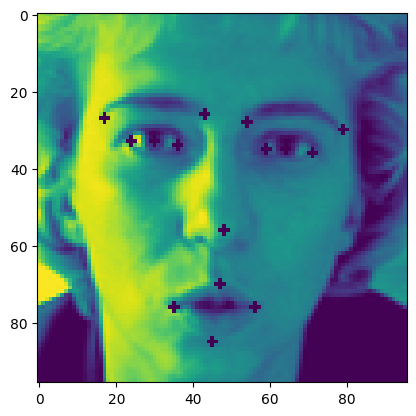

In [177]:
ploted_image = plot_landmarks(faces[1], connected_landmarks[1].values())

plt.imshow(ploted_image)

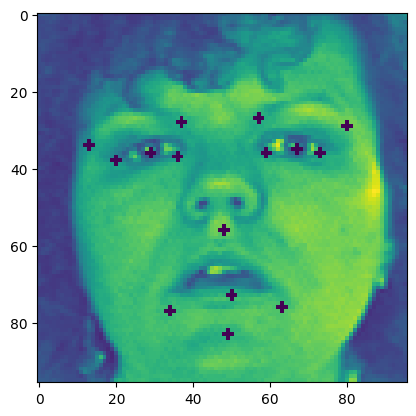

In [176]:
ploted_image = plot_landmarks(faces[500], connected_landmarks[500].values())
plt.imshow(ploted_image)

Neke točke nisu najpreciznije označene, ali to je nedostatak izračunavanja nedostajućih vrijednosti u datasetu i sa tim ćemo morati živjeti.

## Model

Priprema podataka za treniranje modela.

In [190]:
images_input = faces
print("images_input.shape -> ", images_input.shape)

landmarks.keys()



images_input.shape ->  (7000, 96, 96, 1)


Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [167]:
inputs = Input(shape=(96, 96, 1))
x = BatchNormalization()(inputs)
x = Conv2D(128, (3,3), padding="same",kernel_initializer=glorot_uniform(),activation=LeakyReLU(0.1))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = BatchNormalization()(x)
x = Conv2D(256, (3,3), padding="same",kernel_initializer=glorot_uniform(), activation=LeakyReLU(0.1))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = BatchNormalization()(x)
x = Conv2D(512, (3,3), padding="same",kernel_initializer=glorot_uniform(), activation=LeakyReLU(0.1))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x =  Dense(1028, kernel_initializer=glorot_uniform(), activation=LeakyReLU(0.1))(x)
x = Dropout(0.5)(x)
x =  Dense(64, kernel_initializer=glorot_uniform(), activation=LeakyReLU(0.1))(x)
x =  Dense(12, kernel_initializer=glorot_uniform())(x)

model = Model(inputs = inputs, outputs=x)

In [168]:

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=7.1361e-06), metrics=['mean_squared_error'])

In [169]:

def scheduler(epoch, lr):
    """
    Parameters:

        epoch: (integer) representing the current epoch number
        lr: (float) number representing the current learning rate value
    Returns:

        A new floating point number representing the updated learning rate value.
    """
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(-0.09)

    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=60,
    validation_data=(X_test, y_test)
    ,callbacks=[callback])